In [123]:
#http://stat-computing.org/dataexpo/2009/the-data.html

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from datetime import timedelta,date
import datetime
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import graphviz
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestRegressor

In [125]:
# Data for the month of August in 2019 for all flights
data = pd.read_csv('C:/Users/saleh/Desktop/Airline/241868859_T_ONTIME_REPORTING.csv')

C:\Users\saleh\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Check the head of the data get a feel for all the columns. We will only use 100k rows from the data to save computational time

In [126]:
airline_raw = data.sample(n=100000, random_state=100)
del data
airline_raw.head()
#data.describe()

,YEAR,MONTH,DAY_OF_MONTH,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_NM,DEST,...,DIVERTED,AIR_TIME,FLIGHTS,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 31
19905,2019,8,26,DL,N3732J,3014,FAI,"Fairbanks, AK",Alaska,SEA,...,0.0,183.0,1.0,1533.0,NaN,NaN,NaN,NaN,NaN,NaN
92968,2019,8,8,WN,N7819A,1103,LAX,"Los Angeles, CA",California,HOU,...,0.0,178.0,1.0,1390.0,NaN,NaN,NaN,NaN,NaN,NaN
87542,2019,8,30,AS,N549AS,68,SIT,"Sitka, AK",Alaska,SEA,...,0.0,108.0,1.0,861.0,NaN,NaN,NaN,NaN,NaN,NaN
107699,2019,8,14,WN,N243WN,331,DEN,"Denver, CO",Colorado,OAK,...,0.0,125.0,1.0,957.0,12.0,0.0,0.0,0.0,63.0,NaN
317196,2019,8,29,YX,N632RW,3642,IAH,"Houston, TX",Texas,ATL,...,0.0,91.0,1.0,689.0,NaN,NaN,NaN,NaN,NaN,NaN


### Data Cleaning:
1. For consistency, we will lower case all column names. 
2. We will also drop the last column as it has all null values. 
3. We will convert the individual date columns to 1 datetime column and drop unnecessory columns

In [127]:
airline_raw.columns = airline_raw.columns.str.lower() # lower case all column names for consistency

airline_raw = airline_raw.drop(airline_raw.columns[-1],axis=1) # drop last column

# convert date and months columns to datetime and remove individual columns

airline_raw['date'] = pd.to_datetime(airline_raw[['day_of_month','month','year']].astype(str).apply(' '.join, 1), format='%d %m %Y')

airline_raw.drop(['day_of_month','month','year'], axis=1, inplace=True)

### Understand and Fix NULL Values
We will evaluate the NULL values in the data and decide if we need to remove the NULL values or keep them. We are especially interested in the column 'arr_delay'

In [128]:
missing = airline_raw.isnull().mean()*100
missing_values = pd.DataFrame({'column_name': airline_raw.columns,
                                 'percent_missing': missing})
print(missing_values)

                             column_name  percent_missing
op_unique_carrier      op_unique_carrier            0.000
tail_num                        tail_num            0.121
op_carrier_fl_num      op_carrier_fl_num            0.000
origin                            origin            0.000
origin_city_name        origin_city_name            0.000
origin_state_nm          origin_state_nm            0.000
dest                                dest            0.000
dest_city_name            dest_city_name            0.000
dest_state_nm              dest_state_nm            0.000
crs_dep_time                crs_dep_time            0.000
dep_time                        dep_time            1.640
dep_delay                      dep_delay            1.640
taxi_out                        taxi_out            1.727
taxi_in                          taxi_in            1.761
crs_arr_time                crs_arr_time            0.000
arr_time                        arr_time            1.761
arr_delay     

[Text(0, 0, 'op_unique_carrier'),
 Text(0, 0, 'tail_num'),
 Text(0, 0, 'op_carrier_fl_num'),
 Text(0, 0, 'origin'),
 Text(0, 0, 'origin_city_name'),
 Text(0, 0, 'origin_state_nm'),
 Text(0, 0, 'dest'),
 Text(0, 0, 'dest_city_name'),
 Text(0, 0, 'dest_state_nm'),
 Text(0, 0, 'crs_dep_time'),
 Text(0, 0, 'dep_time'),
 Text(0, 0, 'dep_delay'),
 Text(0, 0, 'taxi_out'),
 Text(0, 0, 'taxi_in'),
 Text(0, 0, 'crs_arr_time'),
 Text(0, 0, 'arr_time'),
 Text(0, 0, 'arr_delay'),
 Text(0, 0, 'cancelled'),
 Text(0, 0, 'cancellation_code'),
 Text(0, 0, 'diverted'),
 Text(0, 0, 'air_time'),
 Text(0, 0, 'flights'),
 Text(0, 0, 'distance'),
 Text(0, 0, 'carrier_delay'),
 Text(0, 0, 'weather_delay'),
 Text(0, 0, 'nas_delay'),
 Text(0, 0, 'security_delay'),
 Text(0, 0, 'late_aircraft_delay'),
 Text(0, 0, 'date')]

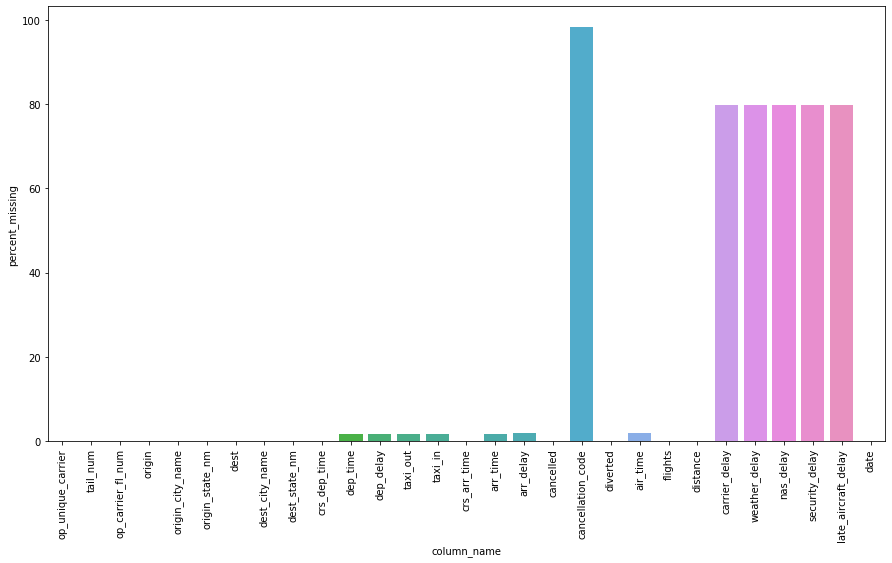

In [130]:
plt.figure(figsize=(15,8))
null_values = sns.barplot(x='column_name',y='percent_missing',data=missing_values)


null_values.set_xticklabels(null_values.get_xticklabels(), rotation=90)

Now we see that wherever a flight is cancelled as mentioned in the 'cancelled' column, the arrival time is null. So considering the scope of our analysis, we will only keep the data for the flights which are not cancelled.

In [131]:
cancel = airline_raw[airline_raw.cancelled==1].copy() # get cancellation data in separate df

airline = airline_raw[airline_raw.cancelled==0].copy() # remove cancellation data from the full data

airline.drop(['cancelled','cancellation_code'], axis=1,inplace=True)

In [ ]:
airline.info()

Now check again to see if we have some Nulls or not.

In [ ]:
# check for NA in arrival time
airline.arr_delay.isnull().sum()

Arrival delay column still has some NULL values, lets explore those.

In [ ]:
# Arrival delay column still has some NULL values, lets explore those.

airline[airline.arr_delay.isnull()==True].describe()

# Seems like all NAs are from flights which have been diverted. Lets verify that.

airline[airline.diverted==0].arr_delay.isnull().sum() # This verifies that no arrival time is listed for diverted flights.

Now we see that wherever a flight is diverted as mentioned in the 'diverted' column, the arrival time is null. So considering the scope of our analysis, we will only keep the data for the flights which are not diverted.

In [132]:
# No arrival time listed for diverted flights, store diverted flights data in deparate df
divert = airline[airline.diverted==1].copy()
airline = airline[airline.diverted==0]
airline.drop(['diverted'], axis=1,inplace=True)

Now explore the output column to check for any extreme values and see the distribution. We have the following observations:
1. There are negative values in the arrival delay column. These values actually are correct and correspond to the occurence where the flight landed earlier then scheduled.
2. There are some very delayed flights (more than 800 minutes ~ 13 hours). These flights also are legit delays for several reasons, so we will keep these in our data as well.

,op_unique_carrier,tail_num,op_carrier_fl_num,origin,origin_city_name,origin_state_nm,dest,dest_city_name,dest_state_nm,crs_dep_time,...,arr_delay,air_time,flights,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,date
293867,YV,N85355,6089,OKC,"Oklahoma City, OK",Oklahoma,IAH,"Houston, TX",Texas,710,...,1571.0,61.0,1.0,395.0,1571.0,0.0,0.0,0.0,0.0,2019-08-02
385194,OO,N150SY,5506,BDL,"Hartford, CT",Connecticut,ORD,"Chicago, IL",Illinois,1315,...,1459.0,155.0,1.0,783.0,0.0,1440.0,19.0,0.0,0.0,2019-08-20
301873,G4,320NV,25,EUG,"Eugene, OR",Oregon,LAS,"Las Vegas, NV",Nevada,2143,...,1222.0,94.0,1.0,700.0,1222.0,0.0,0.0,0.0,0.0,2019-08-12
148009,UA,N596UA,1747,EWR,"Newark, NJ",New Jersey,ANC,"Anchorage, AK",Alaska,1545,...,1198.0,420.0,1.0,3370.0,1040.0,0.0,0.0,0.0,158.0,2019-08-14
55794,YV,N88327,6047,MSP,"Minneapolis, MN",Minnesota,IAD,"Washington, DC",Virginia,1745,...,1196.0,133.0,1.0,908.0,0.0,1196.0,0.0,0.0,0.0,2019-08-05
533630,OO,N247SY,3709,CLE,"Cleveland, OH",Ohio,LGA,"New York, NY",New York,1207,...,1189.0,66.0,1.0,419.0,0.0,1184.0,0.0,0.0,5.0,2019-08-02
564360,UA,N13718,2346,PWM,"Portland, ME",Maine,ORD,"Chicago, IL",Illinois,1300,...,1157.0,139.0,1.0,900.0,499.0,0.0,0.0,0.0,658.0,2019-08-20
392801,OO,N213SY,5445,CLT,"Charlotte, NC",North Carolina,ORD,"Chicago, IL",Illinois,1045,...,1153.0,94.0,1.0,599.0,1153.0,0.0,0.0,0.0,0.0,2019-08-03
511160,OO,N933EV,5405,FAR,"Fargo, ND",North Dakota,DEN,"Denver, CO",Colorado,1656,...,1127.0,93.0,1.0,627.0,1127.0,0.0,0.0,0.0,0.0,2019-08-19
562636,UA,N14120,2215,ANC,"Anchorage, AK",Alaska,IAH,"Houston, TX",Texas,2045,...,1107.0,374.0,1.0,3266.0,804.0,0.0,36.0,0.0,267.0,2019-08-21


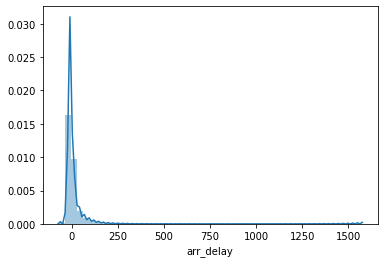

In [148]:
sns.distplot(airline.arr_delay)
airline.arr_delay.describe()

## Check max values for airline delay
airline.sort_values(by='arr_delay',ascending=False)
# airline[airline.arr_delay>800][['op_unique_carrier', 'tail_num', 'op_carrier_fl_num', 'origin',
#                          'origin_city_name', 'origin_state_nm', 'dest', 'dest_city_name',
#                          'dest_state_nm','crs_dep_time','crs_arr_time','air_time','distance','date']].sort_values(by=airline.arr_delay,ascending=False).head() # the delay looks legit and we will keep these extreme values

## Check min values for airline delay
#airline.arr_delay.sort_values(ascending=True).head(5)


In [ ]:
sns.boxplot(airline.arr_delay)

Create a flag for delayed flight. If the flight is more than 15 minutes late, then we will consider it as late.

In [149]:
airline['delayed'] = (airline.arr_delay > 15).astype('int')

In [ ]:
airline.delayed.value_counts()

## Data Cleaning for independent variables
1. We will create all the categorical variables into categories for future analysis.
2. We will only keep independent variables which will be used in model and are available before the flight takes off.

In [ ]:
#sns.pairplot(airline)
#[['UniqueCarrier', 'FlightNum', 'TailNum', 'Origin', 'Dest']]
airline.origin_city_name.value_counts()
#airline.columns

In [150]:

var = ['op_unique_carrier', 'tail_num', 'op_carrier_fl_num', 'origin',
       'origin_city_name', 'origin_state_nm', 'dest', 'dest_city_name',
       'dest_state_nm']
for v in var:
    airline[v] = airline[v].astype('category')


In [151]:
# only keep variables which will be used in model and are available before hand

airline_model = airline[['op_unique_carrier', 'tail_num', 'op_carrier_fl_num', 'origin',
                         'origin_city_name', 'origin_state_nm', 'dest', 'dest_city_name',
                         'dest_state_nm','crs_dep_time','crs_arr_time','air_time','distance','date','delayed']].copy()

Now analyze some of the independent variables to be used in the model

In [153]:
# Check delayed flights by destination 

by_orig = airline_model.groupby('dest').agg(['sum', 'count'])['delayed'].sort_values(by='sum',ascending=False).cumsum()
#by_orig
by_orig = by_orig.reset_index()
#by_orig

Text(0.5, 1.0, 'Total Flights')

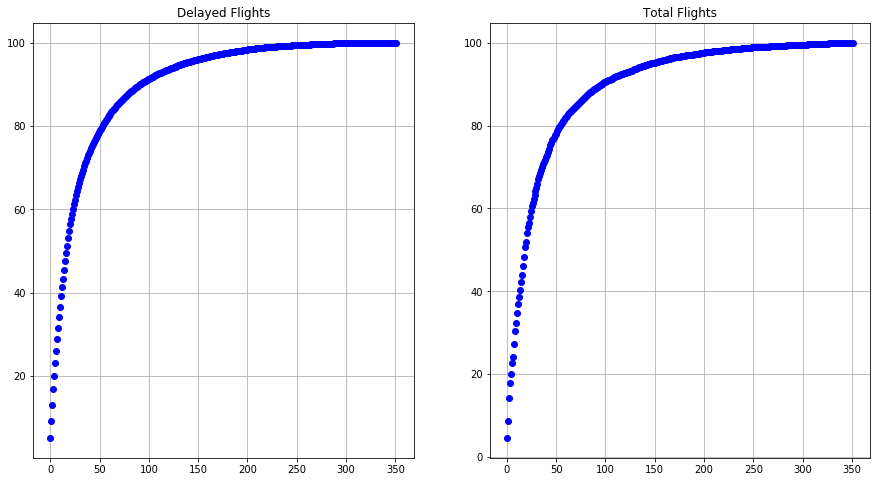

In [154]:
plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
plt.grid()
plt.plot(by_orig['sum']*100/by_orig['sum'].max(),'bo')
plt.title('Delayed Flights')

plt.subplot(1,2,2)
plt.grid()
plt.plot(by_orig['count']*100/by_orig['count'].max(),'bo')
plt.title('Total Flights')

In [ ]:
# We choose top 100 cities, because that makes up more than 90% of data.
airline_top_100 = airline_model[airline_model['dest'].isin(by_orig.dest.head(100))]
airline_top_100.head(10)

In [ ]:
# group by carrier and check the percentage of flights delayed
airline_model.groupby('op_unique_carrier').mean()['delayed']

In [ ]:
# Correlation of the numeric columns with delay of arrival
airline_model.corr()['delayed']

C:\Users\saleh\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


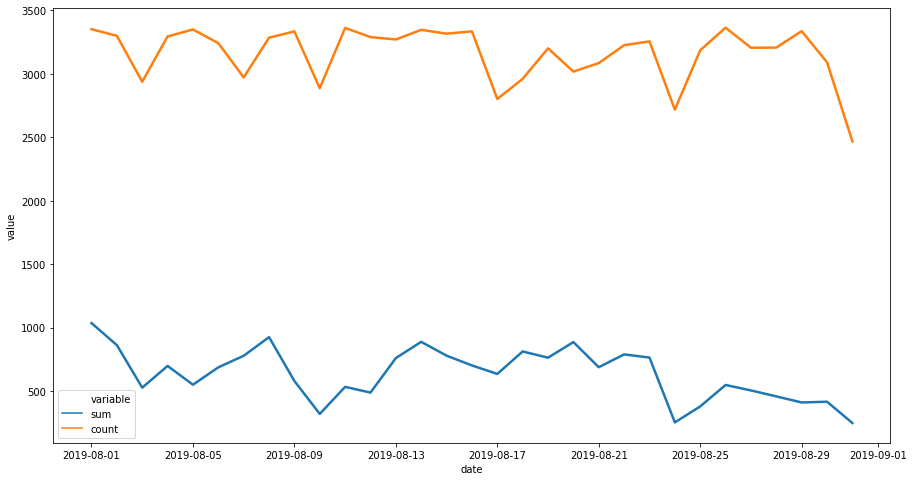

In [155]:
# plot total delayed flight on each day

plt.figure(figsize=(15,8))

plot = airline_model.groupby('date').agg(['sum','count'])['delayed'].reset_index()
#plot.head()
#pd.melt(plot,id_vars=['date'],value_vars=['sum','count']).head(10)

sns.lineplot(x='date', y='value', hue='variable',data=pd.melt(plot,id_vars=['date'],value_vars=['sum','count']), palette="tab10", linewidth=2.5)

# there is not much we can deduce from daily delayed flights

In [156]:
# considering that sun rises at 7AM and sets at 5PM, we will check whether there is any pattern in flights landing 
# during the day or night.

#airline_model.crs_arr_time > 700

#airline_model.loc[airline_model['A'] == df['B'], 'C'] = 0
airline_model.loc[airline_model['crs_arr_time'] < 1700, 'arr_daytime'] = 1
airline_model.loc[airline_model['crs_arr_time'] > 700, 'arr_daytime'] = 1
airline_model.loc[airline_model['crs_arr_time'] < 700, 'arr_daytime'] = 0
airline_model.loc[airline_model['crs_arr_time'] > 1700, 'arr_daytime'] = 0

C:\Users\saleh\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


<Figure size 1080x576 with 0 Axes>

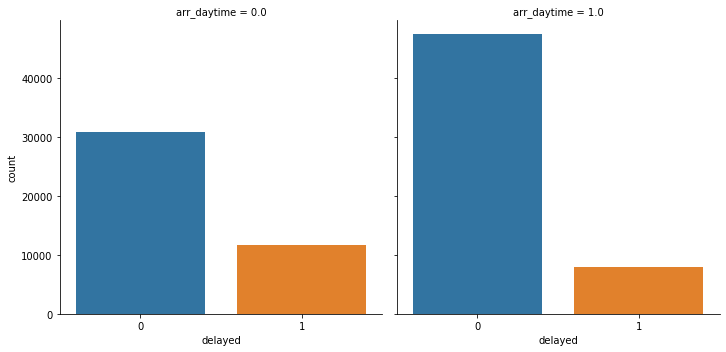

In [157]:
plt.figure(figsize=(15,8))
sns.factorplot(x='delayed', col='arr_daytime', kind='count', data=airline_model);

We can clearly see that flights scheduled to arrive during the night time have a high chance of being delayed

In [12]:
# considering that sun rises at 7AM and sets at 5PM, we will check whether there is any pattern in flights departing 
# during the day or night.


airline_model.loc[airline_model['crs_dep_time'] < 1700, 'dep_daytime'] = 1
airline_model.loc[airline_model['crs_dep_time'] > 700, 'dep_daytime'] = 1
airline_model.loc[airline_model['crs_dep_time'] < 700, 'dep_daytime'] = 0
airline_model.loc[airline_model['crs_dep_time'] > 1700, 'dep_daytime'] = 0

In [ ]:
plt.figure(figsize=(15,8))
sns.factorplot(x='delayed', col='dep_daytime', kind='count', data=airline_model);

In [ ]:
plt.figure(figsize=(15,8))
sns.distplot(airline_model.distance, kde=False);

In [ ]:
plt.figure(figsize=(15,8))
airline_model.groupby('delayed').air_time.hist(alpha=0.5)

In [ ]:
airline_model.groupby('delayed').distance.describe()

In [ ]:
airline_model.groupby('delayed').air_time.describe()

In [160]:
# Check any patterns in day of week

airline_model['dow'] = airline_model.date.dt.day_name()

airline_model.groupby('dow').mean()

,crs_dep_time,crs_arr_time,air_time,distance,delayed,arr_daytime
dow,,,,,,
Friday,1332.461604,1478.035546,110.203162,802.778145,0.203653,0.563829
Monday,1336.581825,1483.889814,110.122378,804.663309,0.177887,0.558803
Saturday,1301.537248,1468.377832,113.778759,837.515239,0.143560,0.591689
Sunday,1353.931584,1495.042877,111.748672,817.104342,0.189160,0.549360
Thursday,1336.466126,1474.067264,110.011745,797.184113,0.238482,0.560211
Tuesday,1329.213001,1480.572348,110.167072,796.867080,0.222815,0.563398
Wednesday,1321.536992,1465.851796,109.883197,796.388946,0.222980,0.572199


## Done with EDA for now.
#### Lets check the final data structure that we have and see if we need to clean it one final time before model

In [162]:
airline_model.tail_num.describe()

# lets drop the following columns because they have too many distinct values:
    #[tail_num,op_carrier_fl_num,crs_dep_time,crs_arr_time]
    
airline_final = airline_model.drop((('tail_num,op_carrier_fl_num,crs_dep_time,crs_arr_time,date,origin_city_name,origin_state_nm,dest_city_name,dest_state_nm').split(',')),axis=1)

In [ ]:
airline_final.info()

Apply the one-hot encoding to categorical variables to be used in the model.

In [163]:
airline_final = pd.get_dummies(airline_final, columns=['op_unique_carrier','origin','dest','dow'])

### Split data into test and train before proceeding to modelling.

In [164]:
# Use train_test_split to split data for model

y = airline_final['delayed']
X = airline_final.drop('delayed',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

In [165]:
# convert to arrays for use with scikit-learn

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

# Decision tree classifier

In [166]:
# Instantiate model and fit to data
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)

pred = clf.predict(X_test)

In [ ]:
dot_data = tree.export_graphviz(clf, out_file=None,feature_names=X.columns, 
                                class_names='delayed',filled=True, rounded=True,special_characters=True) 
graph = graphviz.Source(dot_data) 
graph.render("sample")


In [171]:
#Compute accuracy on the training set
print ("Training Accuracy: {} ".format(clf.score(X_train, y_train)))

#Compute accuracy on the testing set
print ("Test Accuracy: {} ".format(clf.score(X_test, y_test)))

Training Accuracy: 0.8006836473094142 
Test Accuracy: 0.8008775062496811 


Plot a graph for max depth vs accuracy to find the optimum value of depth

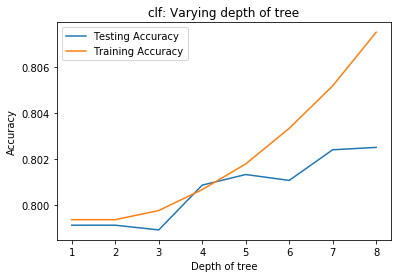

In [168]:
dep = np.arange(1, 9)
train_accuracy = np.empty(len(dep))
test_accuracy = np.empty(len(dep))

# Loop over different values of k
for i, k in enumerate(dep):
    # Setup a Decision Tree Classifier
    clf = tree.DecisionTreeClassifier(max_depth=k)

    # Fit the classifier to the training data
    clf.fit(X_train, y_train)

    #Compute accuracy on the training set
    train_accuracy[i] = clf.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = clf.score(X_test, y_test)

# Generate plot
plt.title('clf: Varying depth of tree')
plt.plot(dep, test_accuracy, label = 'Testing Accuracy')
plt.plot(dep, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Depth of tree')
plt.ylabel('Accuracy')
plt.show()

We have a big jump in the Accuracy if we increase the depth from 3 to 4 so we will re run the model with max depth = 4

In [169]:
# Instantiate model and fit to data
clf = tree.DecisionTreeClassifier(max_depth=4)
clf.fit(X_train, y_train)

pred = clf.predict(X_test)

dot_data = tree.export_graphviz(clf, out_file=None,feature_names=X.columns, 
                                class_names='delayed',filled=True, rounded=True,special_characters=True) 
graph = graphviz.Source(dot_data) 
graph.render("output")

'output.pdf'

In [170]:
print(classification_report(y_test, pred))

print(pd.crosstab(y_test, pred))

              precision    recall  f1-score   support

           0       0.80      0.99      0.89     15664
           1       0.57      0.03      0.07      3937

    accuracy                           0.80     19601
   macro avg       0.69      0.51      0.48     19601
weighted avg       0.76      0.80      0.72     19601

col_0      0    1
row_0            
0      15561  103
1       3800  137


The Recall for predicting the delayed flights has increased from 1% to 3%!

## Random Forrest

In [172]:
# Import the model we are using

min_leaf_samples = 0.03

# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 10, random_state = 100,oob_score = True)#,#max_depth=10,
                           #min_samples_leaf=round(min_leaf_samples*len(X_train)))
# Train the model on training data
rf.fit(X_train, y_train);



C:\Users\saleh\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Not going to print the tree since it has too many nodes.

In [42]:
# # Extract the tree
# rf_tree = rf.estimators_[5]
# # Save the tree

# dot_data = export_graphviz(rf_tree, out_file=None,feature_names=X.columns, 
#                             class_names='delayed',filled=True, rounded=True,special_characters=True) 
# graph = graphviz.Source(dot_data) 
# graph.render("rf_output")

Get the model predictions on the test data and check the precision and recall.

In [173]:
rf_pred = (rf.predict(X_test)> 0.5).astype(int)

print(classification_report(y_test, rf_pred))

print(pd.crosstab(y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.82      0.92      0.87     15664
           1       0.38      0.20      0.26      3937

    accuracy                           0.77     19601
   macro avg       0.60      0.56      0.56     19601
weighted avg       0.73      0.77      0.74     19601

col_0      0     1
row_0             
0      14364  1300
1       3146   791


In [174]:
print('Training Score: {:.2f} \n OOB Score: {:.2f} \n Validation Score: {:.2f}'.format(rf.score(X_train, y_train),rf.oob_score_,rf.score(X_test, y_test)))

Training Score: 0.79 
 OOB Score: -0.27 
 Validation Score: -0.10


As we see that random forrest is not giving us a good validation score. We only get a good training score that means that model is over fitting and will not be able to predict on unknown data.

## Feature Importance
Not going to use for the case of Random Forrest as the model is useless itself

In [121]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X.columns, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
#[print('Variable: {:25} Importance: {}'.format(*pair)) for pair in feature_importances];